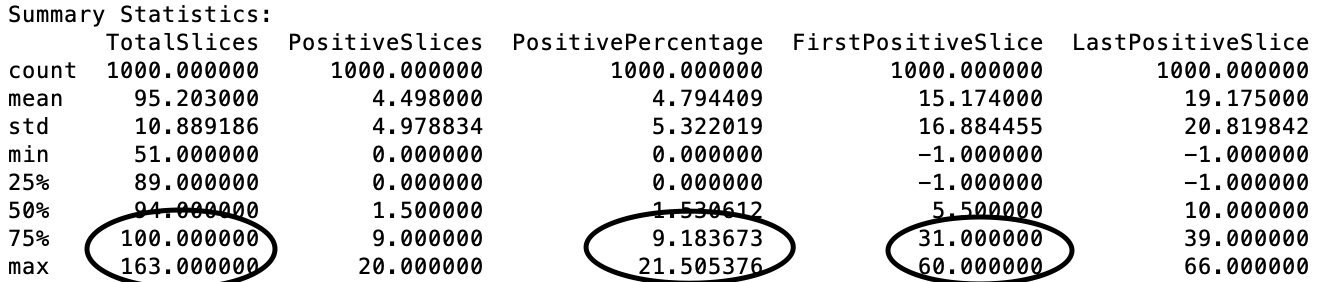

上述資料是由TrainValid_ground_truth.csv統計出來。

PositiveSlices和PositivePercentage是為了概略估算闌尾佔整個腹腔CT的百分比

假設：

1. TotalSlices眾數100

2. 估算闌尾佔整個腹腔CT的百分比30%

3. TotalSlices 100 * 30% = 30, 推估每張CT(每個病人)取Slice 30張

  (闌尾通常位於腹部的右下方，像一根小管子，約有5-10公分左右長)

4. 取Slice的起始點再依病人體型區分為三：



*   TotalSlices < 60，就從該病人TotalSlices * 0.05 開始取30張
*   TotalSlices > 130，就從該病人TotalSlices * 0.2 開始取30張
*   其餘，就從該病人TotalSlices * 0.1 開始取30張

目標是每位病人取出的30張Slice範圍含蓋䦨尾且可排除非必要的Slice來作為訓練。


Data Preproccessing

1. 依TrainValid_split.csv先將資料區分train_data和val_data

2. 讀取Folder，依上述規則取CT Slice 30張

3. 轉PyTorch tensor(torch.tensor)，再進行torch.stack(這30張Slice)

4. 確認每一階段data shape，確保data可以餵進3D CNN model

5. transforms  (torchvision.transforms -> torchio)

建 Model

*   3D CNN model -> 先嘗試 3D resnet model


In [1]:
# Mount to Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
FOLDERNAME = "poster"
%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/poster


In [2]:
!pip install -q torchio   # -q reduce output
!pip install -q pytorchvideo

In [3]:
import os
import torch
import scipy.ndimage as ndimage
import nibabel as nib
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

folder_path = "./dataset/1_Train,Valid_Image"
csv_file = "./dataset/TrainValid_split.csv"

In [4]:
# Transforms
import torchio as tio
SIZE = 224
# Transforms
transform = tio.Compose([
    tio.Resize((50, SIZE, SIZE)), # resize 3D volume
    # tio.RandomFlip(axes=(0, 1, 2)),  # Flip along all three axes 我先把RandomFlip拿掉看看，這樣比較不會破壞器官間的相對位置，看能不能讓AI學到闌尾會固定出現在腹腔左下角
    tio.RandomAffine(scales=(0.9, 1.1), degrees=5, translation=5, isotropic=True),
    tio.Noise(mean=0.0, std=0.1, seed=42)
])

下面這格在做的事情是，把Train,Valid_Image這個資料夾內的所有檔案進行切割，並把切割後的圖檔轉換成torch tensor，存在tensor_list內



In [5]:
# Create Data Loader
class NiftiDataset(Dataset):
  def __init__(self, csv_file, folder_path, group='Train',
               num_slices=50, transform=None):
    """
    csv_file (str): CSV檔的位置
    folder_path (str): Data的資料夾。
    group (str): 要載入'Train' 或 'Valid'
    num_slices (int): 要取幾個 slice
    transform (callable, optional): transformer
    """
    self.csv_file = csv_file
    self.folder_path = folder_path
    self.group = group
    self.num_slices = num_slices
    self.transform = transform

    # 讀取 CSV
    df = pd.read_csv(self.csv_file)

    # 根據 group 篩選需要的資料
    df = df[df['group'] == self.group]

    # 建立檔案路徑與label的清單
    self.file_paths = []
    self.labels = []

    for _, row in df.iterrows():
      file_id = row['id']
      label = row['scan-level label']
      file_path = os.path.join(self.folder_path, file_id + '.nii.gz')
      self.file_paths.append(file_path)
      self.labels.append(label)

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    file_path = self.file_paths[idx]
    label = self.labels[idx]

    # 讀檔
    img = nib.load(file_path)
    data_obj = img.dataobj  # Lazy loading (Do NOT use get_fdata())

    # 獲取影像尺寸
    H, W, D = img.shape

    # 設定適當的 HU window（例如腹部 CT 常見 -100 ~ 400）
    window_min, window_max = -100, 400

    # 計算切片起始索引
    if D < 60:
      start_index = round(D * 0.05)
    elif D > 130:
      start_index = round(D * 0.2)
    else:
      start_index = round(D * 0.1)

    # start_index = max(0, start_index) 這串可以刪掉，因為start_index永遠會比0大
    end_index = min(start_index + self.num_slices, D)

    if (end_index - start_index) != self.num_slices:
      start_index = max(0, end_index - self.num_slices)
      end_index = min(start_index + self.num_slices, D)

    # 只讀取需要的切片
    data_slice = np.array(data_obj[:, :, start_index:end_index], dtype=np.float32)

    # 套用 HU window
    data_slice = np.clip(data_slice, window_min, window_max)
    data_slice = (data_slice - window_min) / (window_max - window_min)

    # 將資料調整至可以丟進model的形式
    data_slice = np.expand_dims(data_slice, axis=0)  # (1, 512, 512, 50) 這邊要有1是因為正常的圖像會有3個channels(RGB)，但CT scan是單色的，所以是1*512*512*30
    data_slice = np.transpose(data_slice, (0, 3, 1, 2))  # (1, 50, 512, 512) 為了符合模型的格式要求
    tensor = torch.tensor(data_slice)

    # transform
    if self.transform:
      tensor = self.transform(tensor)

    # 回傳 (影像Tensor, 標籤)
    return tensor, torch.tensor(label, dtype=torch.long)

In [6]:
scan_train_data = NiftiDataset(csv_file=csv_file, folder_path=folder_path,
              group='Train', num_slices=50, transform=transform)

scan_val_data = NiftiDataset(csv_file=csv_file, folder_path=folder_path,
              group='Valid', num_slices=50, transform=transform)

NUM_TRAIN = len(scan_train_data)
NUM_VAL = len(scan_val_data)

In [7]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Using TorchIO images without a torchio.SubjectsLoader in PyTorch .*"
)

In [8]:
# Create Mini-batches
BATCH = 8
mini_scan_trains = DataLoader(scan_train_data, batch_size=BATCH, shuffle=True)
mini_scan_vals = DataLoader(scan_val_data, batch_size=BATCH)

In [9]:
x, y = next(iter(mini_scan_trains))
print(x.shape, y.shape)

torch.Size([8, 1, 50, 224, 224]) torch.Size([8])


In [10]:
import torch
torch.cuda.empty_cache()

In [11]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [12]:
# Load pretrained model
# import torch.nn as nn
# from pytorchvideo.models.resnet import create_resnet

# model = create_resnet(
#     input_channel=1,
#     model_depth=50,
#     model_num_class=2,
#     norm=torch.nn.BatchNorm3d,
#     dropout_rate=0.5,
# )

# model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)

# model = model.to(device)

In [13]:
!pip install -q torchvision

In [14]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load R3D-18 model (pretrained on Kinetics-400)
model = models.video.r3d_18(pretrained=True)
num_classes = 2  # Example: binary classification (Healthy vs. Appendicitis)
# Modify the first convolutional layer to accept 1 input channel
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
model = model.to(device)

In [16]:
# optimizer and loss function
import torch.optim as optim
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
def val(mini_scan_vals, model, device):
  model.eval()
  with torch.no_grad():
    total = 0
    for x, y in mini_scan_vals:
      x = x.to(device)
      y = y.to(device)
      scores = model(x)
      predictions = scores.argmax(axis=1)
      acc = predictions.eq(y).sum().item()
      total += acc
    print("Val Acc:", total/NUM_VAL)

In [18]:
# Train function
NUM_EPOCHS = 10
PRINT_EVERY = 10

def train(mini_scan_trains, mini_scan_vals, model, loss_function, optimizer, device):
  batch_loss_list = []
  epoch_loss_list = []
  for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for count, (x, y) in enumerate(mini_scan_trains):
      model.train()
      x = x.to(device)
      y = y.to(device)
      scores = model(x)
      loss = loss_function(scores, y)
      if count % PRINT_EVERY == 0:
        print(f'Epoch{epoch + 1}: Training loss:', loss.item(), end = ' / ')
        val(mini_scan_vals, model, device)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      batch_loss_list.append(loss.item())
    val_acc = val(mini_scan_vals, model, device)
    avg_loss = running_loss / NUM_TRAIN
    epoch_loss_list.append(avg_loss)

  # 作圖
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, NUM_EPOCHS+1), epoch_loss_list, marker='o')
  plt.title("Average Loss per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.subplot(1, 2, 2)
  plt.plot(batch_loss_list, marker='.', alpha=0.5)
  plt.title("Loss per Batch")
  plt.xlabel("Batch")
  plt.ylabel("Loss")

  plt.tight_layout()
  plt.show()

In [ ]:
train(mini_scan_trains, mini_scan_vals, model, loss_function, optimizer, device)

Epoch1: Training loss: 0.8275679349899292 / Val Acc: 0.5
Epoch1: Training loss: 0.5164221525192261 / Val Acc: 0.5
Epoch1: Training loss: 0.6566367149353027 / Val Acc: 0.5
Epoch1: Training loss: 0.5365147590637207 / Val Acc: 0.5
Epoch1: Training loss: 0.5686860084533691 / Val Acc: 0.5
Epoch1: Training loss: 0.41282254457473755 / Val Acc: 0.545
Epoch1: Training loss: 0.5676223635673523 / Val Acc: 0.67
Epoch1: Training loss: 0.4473150372505188 / Val Acc: 0.595
Epoch1: Training loss: 0.6875744462013245 / Val Acc: 0.68
Epoch1: Training loss: 0.4276096820831299 / Val Acc: 0.625
Val Acc: 0.605
Epoch2: Training loss: 0.7001457810401917 / Val Acc: 0.64
Epoch2: Training loss: 0.561991274356842 / Val Acc: 0.635
Epoch2: Training loss: 0.6189890503883362 / Val Acc: 0.67
Epoch2: Training loss: 1.1232707500457764 / Val Acc: 0.685
Epoch2: Training loss: 0.43505042791366577 / Val Acc: 0.635
Epoch2: Training loss: 0.4861411452293396 / Val Acc: 0.59
Epoch2: Training loss: 0.6289424300193787 / Val Acc: 0.